In [1]:
import pandas as pd
import numpy as np
import pymysql
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import seaborn
import sklearn
sns.set_theme()

In [2]:
print(pd)
print("pandas v"+pd.__version__)
print("matplotlib v"+matplotlib.__version__)
print("seaborn v"+seaborn.__version__)
print("sklearn v"+sklearn.__version__)

<module 'pandas' from 'C:\\Users\\Napat-PC\\anaconda3\\envs\\tensorflow_nightly\\lib\\site-packages\\pandas\\__init__.py'>
pandas v1.1.2
matplotlib v3.3.2
seaborn v0.11.0
sklearn v0.23.2


## Environment variables

In [3]:
## Define local database connection
MYSQL_HOST = 'localhost'
MYSQL_USER = 'root'
MYSQL_PASSWORD = 'password'
MYSQL_DB = 'f1_db'

# 1) Load data

In [4]:
def get_df(sql_statement):
    cnx = pymysql.connect(host=MYSQL_HOST, user=MYSQL_USER, password=MYSQL_PASSWORD, db=MYSQL_DB)
    df = pd.read_sql(sql_statement, con=cnx)
    cnx.close()
    return df

In [5]:
#### Please note I already prepare this table by using SQL to merge,join,extract then create custom view in my local database

In [6]:
df = get_df(f"""
            SELECT * FROM f1_db.combine_for_prediction;
            """)
df.head()

,driverRef,d_nationality,constructorRef,t_nationality,year,round,grand_prix,circuitRef,statusId,status,...,q2,q2_pos,q3,q3_pos,final_q_pos,pitstop_duration,pitstop_rank,fastest_lap_rank,final_grid,final_pos
0,vettel,German,red_bull,Austrian,2011,1,Australian Grand Prix,albert_park,1,Finished,...,1:24.090,1,1:23.529,1,1,23.32,3,4,1,1
1,hamilton,British,mclaren,British,2011,1,Australian Grand Prix,albert_park,1,Finished,...,1:24.595,2,1:24.307,2,2,23.21,2,8,2,2
2,petrov,Russian,renault,French,2011,1,Australian Grand Prix,albert_park,1,Finished,...,1:25.582,7,1:25.247,6,6,25.11,18,7,6,3
3,alonso,Spanish,ferrari,Italian,2011,1,Australian Grand Prix,albert_park,1,Finished,...,1:25.242,5,1:24.974,5,5,24.06,8,2,5,4
4,webber,Australian,red_bull,Austrian,2011,1,Australian Grand Prix,albert_park,1,Finished,...,1:24.658,3,1:24.395,3,3,24.06,8,3,3,5


# 2) Data Preparation

## Missing data

In [7]:
df.isnull().sum(axis = 0)

driverRef              0
d_nationality          0
constructorRef         0
t_nationality          0
year                   0
round                  0
grand_prix             0
circuitRef             0
statusId               0
status                 0
laps                   0
age_at_race            0
q1                    29
q1_pos                 0
q2                   921
q2_pos                 0
q3                  1849
q3_pos                 0
final_q_pos            0
pitstop_duration       0
pitstop_rank           0
fastest_lap_rank       0
final_grid             0
final_pos              0
dtype: int64

## Features distribution

In [8]:
df.describe()

,year,round,statusId,laps,age_at_race,q1_pos,q2_pos,q3_pos,final_q_pos,pitstop_duration,pitstop_rank,fastest_lap_rank,final_grid,final_pos
count,3780.000000,3780.000000,3780.000000,3780.000000,3780.000000,3780.000000,3780.000000,3780.000000,3780.000000,3780.000000,3780.000000,3780.000000,3780.000000,3780.000000
mean,2015.209524,10.235450,8.403439,56.476984,27.889497,10.505026,9.891270,7.733862,11.090212,24.446738,10.529365,10.538095,10.989947,10.560847
std,2.810974,5.703591,16.437294,12.437481,5.120913,5.900895,5.231105,3.810900,6.246719,3.784602,5.937438,5.978517,6.259190,5.950199
min,2011.000000,1.000000,1.000000,1.000000,17.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,2013.000000,5.000000,1.000000,52.000000,23.900000,5.000000,5.000000,5.000000,6.000000,22.020000,5.000000,5.000000,6.000000,5.000000
50%,2015.000000,10.000000,1.000000,56.000000,27.200000,10.000000,10.000000,9.000000,11.000000,23.580000,10.000000,10.000000,11.000000,10.000000
75%,2018.000000,15.000000,11.000000,66.000000,31.200000,15.000000,15.000000,10.000000,16.000000,25.800000,15.000000,15.000000,16.000000,15.000000
max,2020.000000,21.000000,137.000000,78.000000,43.900000,24.000000,20.000000,20.000000,24.000000,59.290000,24.000000,24.000000,24.000000,24.000000


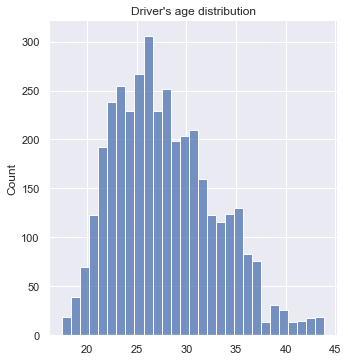

In [9]:
sns.displot(df.loc[:,"age_at_race"].values)
plt.title("Driver's age distribution")
plt.show()

## Correlation Matrix

<AxesSubplot:>

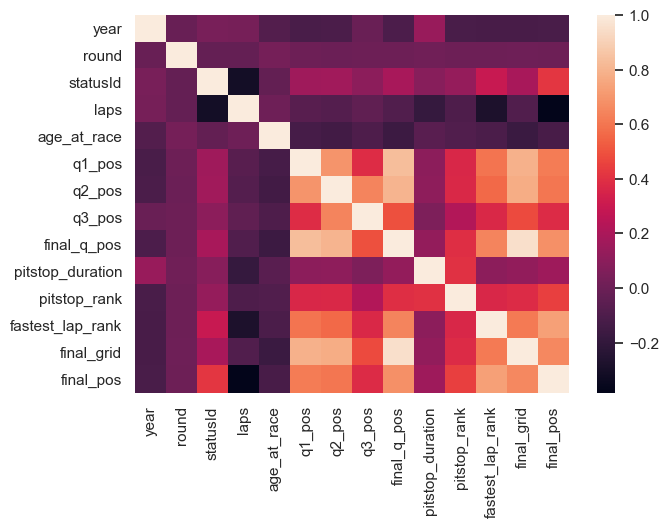

In [10]:
import seaborn as sns
# calculate the correlation matrix
corr = df.corr()

# plot the heatmap
plt.figure(figsize=(7,5), dpi=100)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

## Feature extraction

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3780 entries, 0 to 3779
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   driverRef         3780 non-null   object 
 1   d_nationality     3780 non-null   object 
 2   constructorRef    3780 non-null   object 
 3   t_nationality     3780 non-null   object 
 4   year              3780 non-null   int64  
 5   round             3780 non-null   int64  
 6   grand_prix        3780 non-null   object 
 7   circuitRef        3780 non-null   object 
 8   statusId          3780 non-null   int64  
 9   status            3780 non-null   object 
 10  laps              3780 non-null   int64  
 11  age_at_race       3780 non-null   float64
 12  q1                3751 non-null   object 
 13  q1_pos            3780 non-null   int64  
 14  q2                2859 non-null   object 
 15  q2_pos            3780 non-null   int64  
 16  q3                1931 non-null   object 


### Add Moving Average (SMA), Exponential Moving average (EMA) using past performance position

In [12]:
df_2 = df.copy()
driver_past_performance = { x: np.array([]) for x in df["driverRef"].unique()}
driver_past_ema_5 = { x: np.array([]) for x in df["driverRef"].unique()}
driver_past_ema_10 = { x: np.array([]) for x in df["driverRef"].unique()}
for idx, row in df_2.iterrows():
    SMA_5_pos = round(driver_past_performance[row["driverRef"]][-5:].mean(), 1)
    SMA_10_pos = round(driver_past_performance[row["driverRef"]][-10:].mean(), 1)
    df_2.loc[idx,"SMA_5_pos"] = SMA_5_pos
    df_2.loc[idx,"SMA_10_pos"] = SMA_10_pos
    # EMA_5_pos = x * (2/6) + last_EMA_5_pos * (4/6)
    if len(driver_past_ema_5[row["driverRef"]]) > 0:
        EMA_5_pos = round(driver_past_performance[row["driverRef"]][-1:][0] * (2/6) + driver_past_ema_5[row["driverRef"]][-1:][0] * (4/6), 1)
        EMA_10_pos = round(driver_past_performance[row["driverRef"]][-1:][0] * (2/11) + driver_past_ema_10[row["driverRef"]][-1:][0] * (9/11), 1)
    elif len(driver_past_performance[row["driverRef"]]) > 0 :
        EMA_5_pos = driver_past_performance[row["driverRef"]][-1:][0]
        EMA_10_pos = driver_past_performance[row["driverRef"]][-1:][0]
    else:
        EMA_5_pos = np.nan
        EMA_10_pos = np.nan
    df_2.loc[idx,"EMA_5_pos"] = EMA_5_pos
    df_2.loc[idx,"EMA_10_pos"] = EMA_10_pos
    if row["year"] == 2012 and row["driverRef"] == "hamilton":
        print(f"year = {row['year']}, round = {row['round']}, driver = {row['driverRef']}, last_5_pos = {driver_past_performance[row['driverRef']][-5:]} SMA_5_pos = {SMA_5_pos} EMA_5_pos = {EMA_5_pos} EMA_10_pos = {EMA_10_pos}")
    # Update past performance
    driver_past_performance[row["driverRef"]] = np.append(driver_past_performance[row["driverRef"]], row["final_pos"])
    if not np.isnan(EMA_5_pos):
        driver_past_ema_5[row["driverRef"]] = np.append(driver_past_ema_5[row["driverRef"]], EMA_5_pos)
        driver_past_ema_10[row["driverRef"]] = np.append(driver_past_ema_10[row["driverRef"]], EMA_10_pos)
df_2 = df_2[~pd.isnull(df_2["SMA_5_pos"])]
df_2 = df_2.reset_index(drop=True)

<ipython-input-12-af3ea59ba440>:6: RuntimeWarning: Mean of empty slice.
  SMA_5_pos = round(driver_past_performance[row["driverRef"]][-5:].mean(), 1)
C:\Users\Napat-PC\anaconda3\envs\tensorflow_nightly\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-12-af3ea59ba440>:7: RuntimeWarning: Mean of empty slice.
  SMA_10_pos = round(driver_past_performance[row["driverRef"]][-10:].mean(), 1)


year = 2012, round = 1, driver = hamilton, last_5_pos = [ 5.  2.  7.  1. 22.] SMA_5_pos = 7.4 EMA_5_pos = 10.0 EMA_10_pos = 7.8
year = 2012, round = 2, driver = hamilton, last_5_pos = [ 2.  7.  1. 22.  3.] SMA_5_pos = 7.0 EMA_5_pos = 7.7 EMA_10_pos = 6.9
year = 2012, round = 3, driver = hamilton, last_5_pos = [ 7.  1. 22.  3.  3.] SMA_5_pos = 7.2 EMA_5_pos = 6.1 EMA_10_pos = 6.2
year = 2012, round = 4, driver = hamilton, last_5_pos = [ 1. 22.  3.  3.  3.] SMA_5_pos = 6.4 EMA_5_pos = 5.1 EMA_10_pos = 5.6
year = 2012, round = 5, driver = hamilton, last_5_pos = [22.  3.  3.  3.  8.] SMA_5_pos = 7.8 EMA_5_pos = 6.1 EMA_10_pos = 6.0
year = 2012, round = 6, driver = hamilton, last_5_pos = [3. 3. 3. 8. 8.] SMA_5_pos = 5.0 EMA_5_pos = 6.7 EMA_10_pos = 6.4
year = 2012, round = 7, driver = hamilton, last_5_pos = [3. 3. 8. 8. 5.] SMA_5_pos = 5.4 EMA_5_pos = 6.1 EMA_10_pos = 6.1
year = 2012, round = 8, driver = hamilton, last_5_pos = [3. 8. 8. 5. 1.] SMA_5_pos = 5.0 EMA_5_pos = 4.4 EMA_10_pos = 5.

### Shuffle data

In [13]:
df_3 = df_2.sample(frac=1, random_state=99).copy()

# 3) Create baseline model

## Model A1 - Predict Final Position equal Grid position

In [14]:
### Train data: year 2012 - 2018
### Test data: year 2019

In [15]:
X_train = df_3.copy()
X_test = df_3.copy()
X_train = X_train[(X_train["year"] >= 2012) & (X_train["year"] <= 2018)]
X_test = X_test[X_test["year"] == 2019]
y_train = X_train["final_pos"].to_numpy()
y_test = X_test["final_pos"].to_numpy()
X_train = X_train.drop(columns=["final_pos"])
X_train = X_train.reset_index(drop=True)
X_test = X_test.drop(columns=["final_pos"])
X_test = X_test.reset_index(drop=True)

In [16]:
print(f"train size = {len(X_train)}")
print(f"test size = {len(X_test)}")

train size = 2700
test size = 403


### Feature selection

In [17]:
X_train_a1 = X_train[["final_grid"]].copy()
X_test_a1 = X_test[["final_grid"]].copy()

### Define Model 

In [18]:
y_train_a1_pred = X_train_a1["final_grid"].to_numpy()
y_test_a1_pred = X_test_a1["final_grid"].to_numpy()
display(pd.DataFrame({"y_train_pred":y_train_a1_pred,"y_train_actual":y_train}).head())

,y_train_pred,y_train_actual
0,8,4
1,5,4
2,19,15
3,5,8
4,10,7


### Model evaluation on Train data

In [19]:
from sklearn.metrics import mean_absolute_error
model_a1_train_mae = round(mean_absolute_error(y_train, y_train_a1_pred),3)
print(f"(Model A1) Train MAE = {model_a1_train_mae}")

(Model A1) Train MAE = 3.617


In [20]:
from sklearn.metrics import r2_score
model_a1_train_r2 = round(r2_score(y_train, y_train_a1_pred),3)
print(f"(Model A1) Train R-squared = {model_a1_train_r2}")
model_a1_adj_train_r2 = round((1 - (1 - model_a1_train_r2) * ((X_train_a1.shape[0] - 1) / (X_train_a1.shape[0] - X_train_a1.shape[1] - 1))), 3)
print(f"(Model A1) Train Adjusted R-squared = {model_a1_adj_train_r2}")

(Model A1) Train R-squared = 0.252
(Model A1) Train Adjusted R-squared = 0.252


### Model evaluation on Test data

In [21]:
from sklearn.metrics import mean_absolute_error
model_a1_test_mae = round(mean_absolute_error(y_test, y_test_a1_pred),3)
print(f"(Model A1) Test MAE = {model_a1_test_mae}")

(Model A1) Test MAE = 3.481


In [22]:
from sklearn.metrics import r2_score
model_a1_test_r2 = round(r2_score(y_test, y_test_a1_pred),3)
print(f"(Model A1) Test R-squared = {model_a1_test_r2}")
model_a1_adj_test_r2 = round((1 - (1 - model_a1_test_r2) * ((X_test_a1.shape[0] - 1) / (X_test_a1.shape[0] - X_test_a1.shape[1] - 1))), 3)
print(f"(Model A1) Test Adjusted R-squared = {model_a1_adj_test_r2}")

(Model A1) Test R-squared = 0.198
(Model A1) Test Adjusted R-squared = 0.196


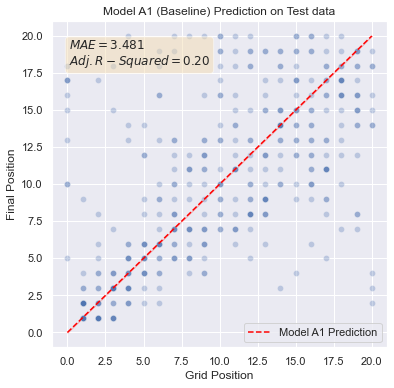

In [23]:
sns.set_theme()
f, ax = plt.subplots(figsize=(6, 6))
sns.lineplot(x=X_test_a1["final_grid"], y=y_test_a1_pred, color="red", linestyle="--")
sns.scatterplot(x=X_test_a1["final_grid"], y=y_test, alpha=0.3)
ax.set_xlabel("Grid Position")
ax.set_ylabel("Final Position")
plt.legend(["Model A1 Prediction"])
plt.title("Model A1 (Baseline) Prediction on Test data")
textstr = '\n'.join((
    r'$MAE=%.3f$' % (model_a1_test_mae, ),
    r'$Adj. R-Squared=%.2f$' % (model_a1_adj_test_r2, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.show()

### Intrepret the result

After define <b>model A1</b> by predicting final position using grid position <br>
the model has <b>MAE on Test data = 3.481</b> and <b>Adjusted R-Squared ~ 20%</b>

## Model A2 - Using Linear Regression One variable

In [24]:
X_train_a2 = X_train.copy()
X_train_a2 = X_train_a2[["final_grid"]]
X_test_a2 = X_test.copy()
X_test_a2 = X_test_a2[["final_grid"]]
X_train_a2.head()

,final_grid
0,8
1,5
2,19
3,5
4,10


### Train model

In [26]:
from sklearn.linear_model import LinearRegression
# Loss function = Residual sum of squares
model_a2 = LinearRegression(fit_intercept=True, normalize=False)
model_a2.fit(X_train_a2.to_numpy(), y_train)

LinearRegression()

In [27]:
model_a2.coef_

array([0.6168936])

In [28]:
model_a2.intercept_

3.680320410763785

### Model evaluation on Train data

In [29]:
y_train_a2_pred = model_a2.predict(X_train_a2)

In [30]:
from sklearn.metrics import mean_absolute_error
model_a2_train_mae = round(mean_absolute_error(y_train, y_train_a2_pred),3)
print(f"(Model A2) Train MAE = {model_a2_train_mae}")

(Model A2) Train MAE = 3.403


In [31]:
from sklearn.metrics import r2_score
model_a2_train_r2 = round(r2_score(y_train, y_train_a2_pred),3)
print(f"(Model A2) Train R-squared = {model_a2_train_r2}")
model_a2_adj_train_r2 = round((1 - (1 - model_a2_train_r2) * ((X_train_a2.shape[0] - 1) / (X_train_a2.shape[0] - X_train_a2.shape[1] - 1))), 3)
print(f"(Model A2) Train Adjusted R-squared = {model_a2_adj_train_r2}")

(Model A2) Train R-squared = 0.423
(Model A2) Train Adjusted R-squared = 0.423


### Model evaluation on Test data

In [32]:
y_test_a2_pred = model_a2.predict(X_test_a2)

In [33]:
from sklearn.metrics import mean_absolute_error
model_a2_test_mae = round(mean_absolute_error(y_test, y_test_a2_pred),3)
print(f"(Model A2) Test MAE = {model_a2_test_mae}")

(Model A2) Test MAE = 3.498


In [34]:
from sklearn.metrics import r2_score
model_a2_test_r2 = round(r2_score(y_test, y_test_a2_pred),3)
print(f"(Model A2) Test R-squared = {model_a2_test_r2}")
model_a2_adj_test_r2 = round((1 - (1 - model_a2_test_r2) * ((X_test_a2.shape[0] - 1) / (X_test_a2.shape[0] - X_test_a2.shape[1] - 1))), 3)
print(f"(Model A2) Test Adjusted R-squared = {model_a2_adj_test_r2}")

(Model A2) Test R-squared = 0.363
(Model A2) Test Adjusted R-squared = 0.361


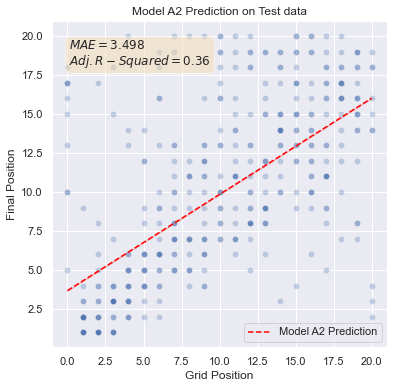

In [35]:
sns.set_theme()
f, ax = plt.subplots(figsize=(6, 6))
sns.lineplot(x=X_test_a2["final_grid"], y=y_test_a2_pred, color="red", linestyle="--")
sns.scatterplot(x=X_test_a2["final_grid"], y=y_test, alpha=0.3)
ax.set_xlabel("Grid Position")
ax.set_ylabel("Final Position")
plt.legend(["Model A2 Prediction"])
plt.title("Model A2 Prediction on Test data")
textstr = '\n'.join((
    r'$MAE=%.3f$' % (model_a2_test_mae, ),
    r'$Adj. R-Squared=%.2f$' % (model_a2_adj_test_r2, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.show()

### Intrepret the result

After define <b>model A2</b> by using Linear regression One variable (Grid position) <br>
Coeff = 0.6, Intercept = 3.7 <br>
the model has <b>MAE on Test data = 3.498</b> and <b>Adjusted R-Squared ~ 36%</b><br>

## Model A3 - Using Linear Regression multiple variables

### Feature selection

In [36]:
features = ["age_at_race","q1_pos","q2_pos","q3_pos","final_q_pos","final_grid","pitstop_rank","fastest_lap_rank"]
X_train_a3 = X_train.copy()
X_train_a3 = X_train_a3[features]
X_test_a3 = X_test.copy()
X_test_a3 = X_test_a3[features]
X_train_a3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age_at_race       2700 non-null   float64
 1   q1_pos            2700 non-null   int64  
 2   q2_pos            2700 non-null   int64  
 3   q3_pos            2700 non-null   int64  
 4   final_q_pos       2700 non-null   int64  
 5   final_grid        2700 non-null   int64  
 6   pitstop_rank      2700 non-null   int64  
 7   fastest_lap_rank  2700 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 168.9 KB


### Standardize features

In [37]:
from sklearn.preprocessing import StandardScaler
X_train_a3_t = X_train_a3.copy()
X_test_a3_t = X_test_a3.copy()
scaler = StandardScaler().fit(X_train_a3_t[features].values)
X_train_a3_t[features] = scaler.transform(X_train_a3_t[features].values)
X_test_a3_t[features] = scaler.transform(X_test_a3_t[features].values)
X_train_a3_t.describe()

,age_at_race,q1_pos,q2_pos,q3_pos,final_q_pos,final_grid,pitstop_rank,fastest_lap_rank
count,2.700000e+03,2.700000e+03,2.700000e+03,2.700000e+03,2.700000e+03,2.700000e+03,2.700000e+03,2.700000e+03
mean,5.276438e-16,2.302685e-17,-1.973730e-17,9.210739e-18,-8.158083e-17,-7.105427e-17,-6.710681e-17,-7.105427e-17
std,1.000185e+00,1.000185e+00,1.000185e+00,1.000185e+00,1.000185e+00,1.000185e+00,1.000185e+00,1.000185e+00
min,-2.077147e+00,-1.606863e+00,-1.704869e+00,-1.840714e+00,-1.608574e+00,-1.761762e+00,-1.601636e+00,-1.757326e+00
25%,-7.736037e-01,-9.223361e-01,-9.279340e-01,-7.468594e-01,-8.047929e-01,-7.977170e-01,-9.214822e-01,-9.118856e-01
50%,-1.042164e-01,-6.667795e-02,4.323500e-02,3.469949e-01,-1.012168e-03,5.653347e-03,-7.129018e-02,-6.644534e-02
75%,6.456987e-01,7.889802e-01,8.201702e-01,6.204585e-01,8.027686e-01,8.090237e-01,7.789019e-01,7.789949e-01
max,3.237687e+00,2.329165e+00,1.985573e+00,3.355094e+00,2.088818e+00,2.094416e+00,2.309248e+00,2.300787e+00


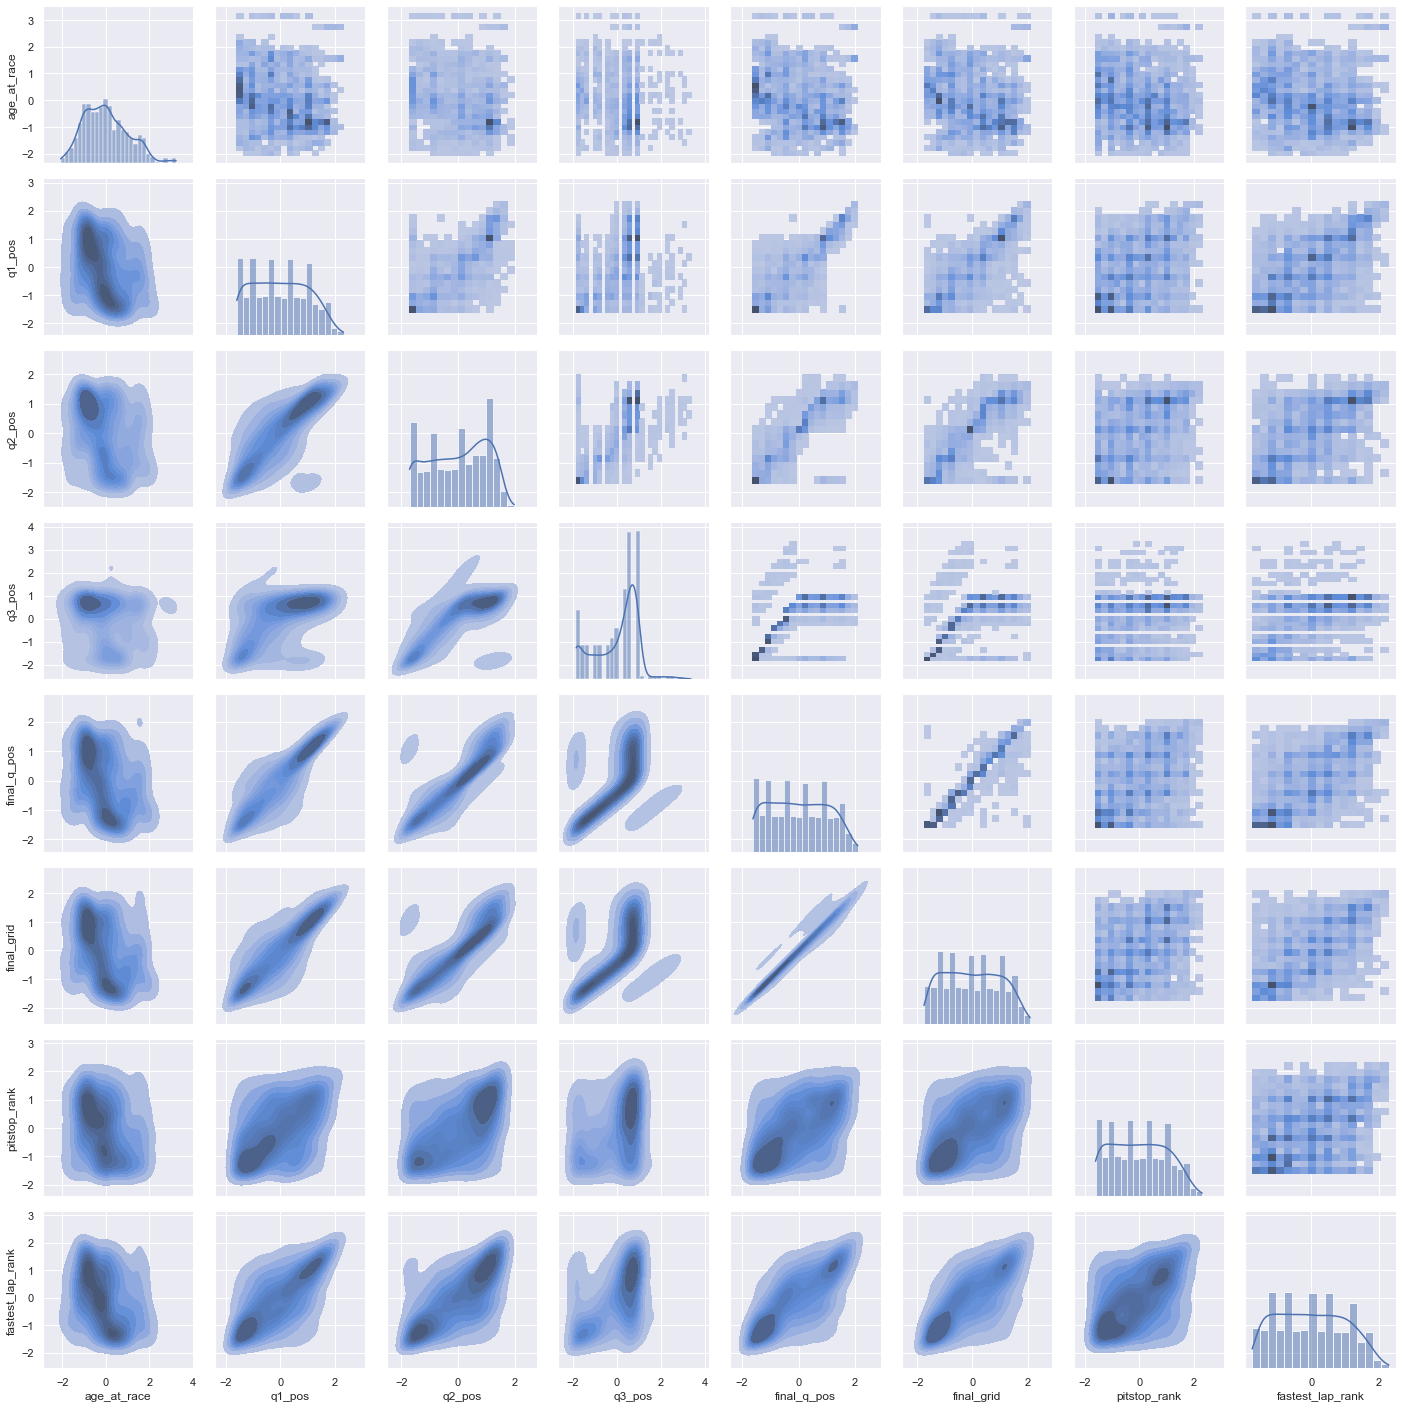

In [38]:
g = sns.PairGrid(X_train_a3_t)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)
plt.show()

### Train model

In [40]:
from sklearn.linear_model import LinearRegression
# Loss function = Residual sum of squares
model_a3 = LinearRegression()
model_a3.fit(X_train_a3_t.to_numpy(), y_train)

LinearRegression()

In [41]:
model_a3.coef_

array([-0.02744357,  0.16909773,  0.41866372, -0.03657555,  1.09316576,
        0.39726634,  0.89600616,  2.66259304])

In [42]:
model_a3.intercept_

10.444444444444445

### Model evaluation on Train data

In [43]:
y_train_a3_pred = model_a3.predict(X_train_a3_t)

In [44]:
from sklearn.metrics import mean_absolute_error
model_a3_train_mae = round(mean_absolute_error(y_train, y_train_a3_pred),3)
print(f"(Model A3) Train MAE = {model_a3_train_mae}")

(Model A3) Train MAE = 2.702


In [45]:
from sklearn.metrics import r2_score
model_a3_train_r2 = round(r2_score(y_train, y_train_a3_pred),3)
print(f"(Model A3) Train R-squared = {model_a3_train_r2}")
model_a3_adj_train_r2 = round((1 - (1 - model_a3_train_r2) * ((X_train_a3.shape[0] - 1) / (X_train_a3.shape[0] - X_train_a3.shape[1] - 1))), 3)
print(f"(Model A3) Train Adjusted R-squared = {model_a3_adj_train_r2}")

(Model A3) Train R-squared = 0.619
(Model A3) Train Adjusted R-squared = 0.618


### Model evaluation on Test data

In [46]:
y_test_a3_pred = model_a3.predict(X_test_a3_t)

In [47]:
from sklearn.metrics import mean_absolute_error
model_a3_test_mae = round(mean_absolute_error(y_test, y_test_a3_pred),3)
print(f"(Model A3) Test MAE = {model_a3_test_mae}")

(Model A3) Test MAE = 2.613


In [48]:
from sklearn.metrics import r2_score
model_a3_test_r2 = round(r2_score(y_test, y_test_a3_pred),3)
print(f"(Model A3) Test R-squared = {model_a3_test_r2}")
model_a3_adj_test_r2 = round((1 - (1 - model_a3_test_r2) * ((X_test_a3.shape[0] - 1) / (X_test_a3.shape[0] - X_test_a3.shape[1] - 1))), 3)
print(f"(Model A3) Test Adjusted R-squared = {model_a3_adj_test_r2}")

(Model A3) Test R-squared = 0.62
(Model A3) Test Adjusted R-squared = 0.612


### Interpret the result

After define <b>model A3</b> by using Linear regression Mulitple variables <br>
Features = [age_at_race, q1_pos, q2_pos, q3_pos, final_q_pos, final_grid, pitstop_rank, fastest_lap_rank]<br>
Coeff = [-0.02744357,  0.16909773,  0.41866372, -0.03657555,  1.09316576, 0.39726634,  0.89600616,  2.66259304], Intercept = 10.4 <br>
the model has <b>MAE on Test data = 2.613</b> and <b>Adjusted R-Squared ~ 61%</b><br>

In [49]:
# summarize feature importance
features_importance = list(zip(X_train_a3.columns,model_a3.coef_))
sorted_features_importance_a3 = sorted(features_importance, key=lambda a: abs(a[1]), reverse=True)
for i,v in sorted_features_importance_a3:
	print('Feature: %s, Score: %.5f' % (i,v))

Feature: fastest_lap_rank, Score: 2.66259
Feature: final_q_pos, Score: 1.09317
Feature: pitstop_rank, Score: 0.89601
Feature: q2_pos, Score: 0.41866
Feature: final_grid, Score: 0.39727
Feature: q1_pos, Score: 0.16910
Feature: q3_pos, Score: -0.03658
Feature: age_at_race, Score: -0.02744


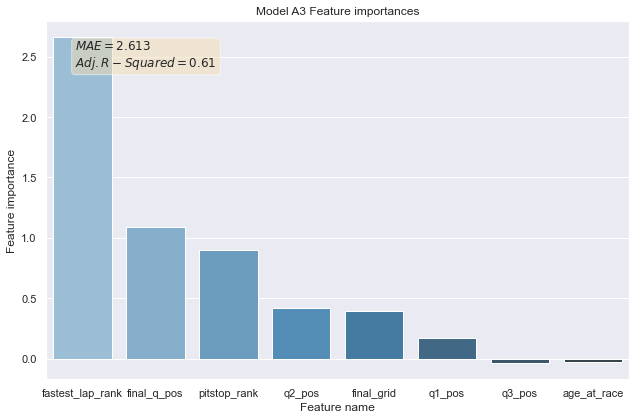

In [50]:
f, ax = plt.subplots(figsize=(9, 6))
ax = sns.barplot(x=0, y=1, data=pd.DataFrame(sorted_features_importance_a3), palette="Blues_d")
ax.set_xlabel("Feature name")
ax.set_ylabel("Feature importance")
plt.title("Model A3 Feature importances")
textstr = '\n'.join((
    r'$MAE=%.3f$' % (model_a3_test_mae, ),
    r'$Adj. R-Squared=%.2f$' % (model_a3_adj_test_r2, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()

## Model A4 - Add SMA, EMA of driver past performance

### Feature Selection

In [51]:
features = ["age_at_race","q1_pos","q2_pos","q3_pos","final_q_pos","final_grid","pitstop_rank","fastest_lap_rank","SMA_5_pos","SMA_10_pos","EMA_5_pos","EMA_10_pos"]
X_train_a4 = X_train.copy()
X_train_a4 = X_train_a4[features]
X_test_a4 = X_test.copy()
X_test_a4 = X_test_a4[features]
X_train_a4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age_at_race       2700 non-null   float64
 1   q1_pos            2700 non-null   int64  
 2   q2_pos            2700 non-null   int64  
 3   q3_pos            2700 non-null   int64  
 4   final_q_pos       2700 non-null   int64  
 5   final_grid        2700 non-null   int64  
 6   pitstop_rank      2700 non-null   int64  
 7   fastest_lap_rank  2700 non-null   int64  
 8   SMA_5_pos         2700 non-null   float64
 9   SMA_10_pos        2700 non-null   float64
 10  EMA_5_pos         2700 non-null   float64
 11  EMA_10_pos        2700 non-null   float64
dtypes: float64(5), int64(7)
memory usage: 253.2 KB


### Standardize features

In [52]:
from sklearn.preprocessing import StandardScaler
X_train_a4_t = X_train_a4.copy()
X_test_a4_t = X_test_a4.copy()
scaler = StandardScaler().fit(X_train_a4_t[features].values)
X_train_a4_t[features] = scaler.transform(X_train_a4_t[features].values)
X_test_a4_t[features] = scaler.transform(X_test_a4_t[features].values)
X_train_a4_t.describe()

,age_at_race,q1_pos,q2_pos,q3_pos,final_q_pos,final_grid,pitstop_rank,fastest_lap_rank,SMA_5_pos,SMA_10_pos,EMA_5_pos,EMA_10_pos
count,2.700000e+03,2.700000e+03,2.700000e+03,2.700000e+03,2.700000e+03,2.700000e+03,2.700000e+03,2.700000e+03,2.700000e+03,2.700000e+03,2.700000e+03,2.700000e+03
mean,5.276438e-16,2.302685e-17,-1.973730e-17,9.210739e-18,-8.158083e-17,-7.105427e-17,-6.710681e-17,-7.105427e-17,-7.894919e-17,-2.894804e-17,-1.526351e-16,1.986888e-16
std,1.000185e+00,1.000185e+00,1.000185e+00,1.000185e+00,1.000185e+00,1.000185e+00,1.000185e+00,1.000185e+00,1.000185e+00,1.000185e+00,1.000185e+00,1.000185e+00
min,-2.077147e+00,-1.606863e+00,-1.704869e+00,-1.840714e+00,-1.608574e+00,-1.761762e+00,-1.601636e+00,-1.757326e+00,-2.050389e+00,-2.096210e+00,-2.033475e+00,-2.019962e+00
25%,-7.736037e-01,-9.223361e-01,-9.279340e-01,-7.468594e-01,-8.047929e-01,-7.977170e-01,-9.214822e-01,-9.118856e-01,-7.454709e-01,-7.339701e-01,-7.459438e-01,-7.333947e-01
50%,-1.042164e-01,-6.667795e-02,4.323500e-02,3.469949e-01,-1.012168e-03,5.653347e-03,-7.129018e-02,-6.644534e-02,3.748016e-02,6.067015e-02,6.149114e-02,5.922296e-02
75%,6.456987e-01,7.889802e-01,8.201702e-01,6.204585e-01,8.027686e-01,8.090237e-01,7.789019e-01,7.789949e-01,7.769340e-01,7.871983e-01,7.816358e-01,7.829173e-01
max,3.237687e+00,2.329165e+00,1.985573e+00,3.355094e+00,2.088818e+00,2.094416e+00,2.309248e+00,2.300787e+00,2.386333e+00,2.399183e+00,2.418328e+00,2.437076e+00


### Train model

In [53]:
from sklearn.linear_model import LinearRegression
# Loss function = Residual sum of squares
model_a4 = LinearRegression()
model_a4.fit(X_train_a4_t.to_numpy(), y_train)

LinearRegression()

In [54]:
model_a4.coef_

array([ 0.04173682,  0.09767421,  0.36510202, -0.04007599,  0.74162   ,
        0.3845562 ,  0.802176  ,  2.4512337 ,  0.28395274,  0.52796058,
       -0.22810427,  0.27243657])

In [55]:
model_a4.intercept_

10.444444444444445

### Model evaluation on Train data

In [56]:
y_train_a4_pred = model_a4.predict(X_train_a4_t)

In [57]:
from sklearn.metrics import mean_absolute_error
model_a4_train_mae = round(mean_absolute_error(y_train, y_train_a4_pred),3)
print(f"(Model A4) Train MAE = {model_a4_train_mae}")

(Model A4) Train MAE = 2.678


In [58]:
from sklearn.metrics import r2_score
model_a4_train_r2 = round(r2_score(y_train, y_train_a4_pred),3)
print(f"(Model A4) Train R-squared = {model_a4_train_r2}")
model_a4_adj_train_r2 = round((1 - (1 - model_a4_train_r2) * ((X_train_a4.shape[0] - 1) / (X_train_a4.shape[0] - X_train_a4.shape[1] - 1))), 3)
print(f"(Model A4) Train Adjusted R-squared = {model_a4_adj_train_r2}")

(Model A4) Train R-squared = 0.626
(Model A4) Train Adjusted R-squared = 0.624


### Model evaluation on Test data

In [59]:
y_test_a4_pred = model_a4.predict(X_test_a4_t)

In [60]:
from sklearn.metrics import mean_absolute_error
model_a4_test_mae = round(mean_absolute_error(y_test, y_test_a4_pred),3)
print(f"(Model A4) Test MAE = {model_a4_test_mae}")

(Model A4) Test MAE = 2.564


In [61]:
from sklearn.metrics import r2_score
model_a4_test_r2 = round(r2_score(y_test, y_test_a4_pred),3)
print(f"(Model A4) Test R-squared = {model_a4_test_r2}")
model_a4_adj_test_r2 = round((1 - (1 - model_a4_test_r2) * ((X_test_a4.shape[0] - 1) / (X_test_a4.shape[0] - X_test_a4.shape[1] - 1))), 3)
print(f"(Model A4) Test Adjusted R-squared = {model_a4_adj_test_r2}")

(Model A4) Test R-squared = 0.626
(Model A4) Test Adjusted R-squared = 0.614


### Interpret the result

After define <b>model A4</b> by adding SMA, EMA of past performance <br>
the model has <b>MAE on Test data = 2.564</b> and <b>Adjusted R-Squared ~ 61%</b><br>

### Feature importances

In [62]:
# summarize feature importance
features_importance = list(zip(X_train_a4.columns,model_a4.coef_))
sorted_features_importance_a4 = sorted(features_importance, key=lambda a: abs(a[1]), reverse=True)
for i,v in sorted_features_importance_a4:
	print('Feature: %s, Score: %.5f' % (i,v))

Feature: fastest_lap_rank, Score: 2.45123
Feature: pitstop_rank, Score: 0.80218
Feature: final_q_pos, Score: 0.74162
Feature: SMA_10_pos, Score: 0.52796
Feature: final_grid, Score: 0.38456
Feature: q2_pos, Score: 0.36510
Feature: SMA_5_pos, Score: 0.28395
Feature: EMA_10_pos, Score: 0.27244
Feature: EMA_5_pos, Score: -0.22810
Feature: q1_pos, Score: 0.09767
Feature: age_at_race, Score: 0.04174
Feature: q3_pos, Score: -0.04008


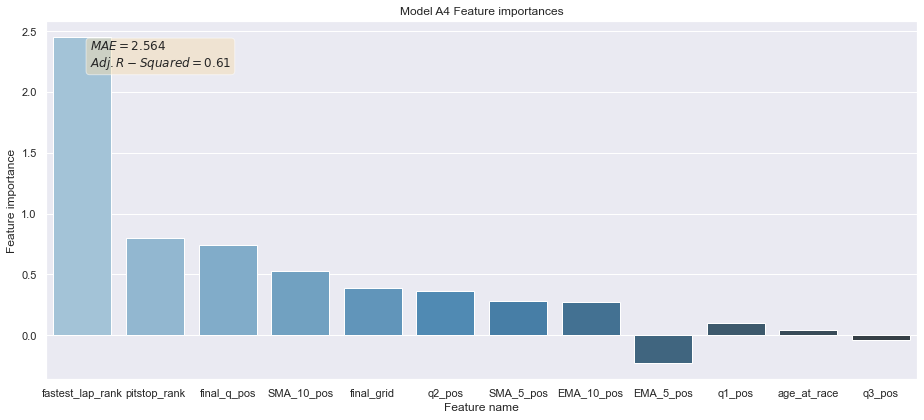

In [63]:
f, ax = plt.subplots(figsize=(13, 6))
ax = sns.barplot(x=0, y=1, data=pd.DataFrame(sorted_features_importance_a4), palette="Blues_d")
ax.set_xlabel("Feature name")
ax.set_ylabel("Feature importance")
plt.title("Model A4 Feature importances")
textstr = '\n'.join((
    r'$MAE=%.3f$' % (model_a4_test_mae, ),
    r'$Adj. R-Squared=%.2f$' % (model_a4_adj_test_r2, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()

In [64]:
import copy
def get_sorted_corr(dataframe):
    c = dataframe.corr().abs()
    s = c.unstack()
    so = s.sort_values(kind="quicksort",ascending=False)
    # To exclude identity feature (corr = 1)
    new_so = copy.deepcopy(so)
    for i in range(len(so)):
        if so[[i]].index[0][0] == so[[i]].index[0][1]:
            new_so = new_so.drop(so[[i]].index)
    return new_so

#### Top High-correlations feature

In [65]:
# Top 10 High-correlations feature
get_sorted_corr(X_train_a4)[:30]

SMA_10_pos   EMA_10_pos     0.986081
EMA_10_pos   SMA_10_pos     0.986081
EMA_5_pos    EMA_10_pos     0.983318
EMA_10_pos   EMA_5_pos      0.983318
EMA_5_pos    SMA_5_pos      0.979536
SMA_5_pos    EMA_5_pos      0.979536
EMA_10_pos   SMA_5_pos      0.977032
SMA_5_pos    EMA_10_pos     0.977032
final_grid   final_q_pos    0.958628
final_q_pos  final_grid     0.958628
SMA_5_pos    SMA_10_pos     0.956759
SMA_10_pos   SMA_5_pos      0.956759
EMA_5_pos    SMA_10_pos     0.954498
SMA_10_pos   EMA_5_pos      0.954498
final_q_pos  q1_pos         0.829556
q1_pos       final_q_pos    0.829556
final_q_pos  q2_pos         0.828204
q2_pos       final_q_pos    0.828204
             final_grid     0.800030
final_grid   q2_pos         0.800030
             q1_pos         0.786184
q1_pos       final_grid     0.786184
final_q_pos  EMA_10_pos     0.770320
EMA_10_pos   final_q_pos    0.770320
SMA_10_pos   final_q_pos    0.766335
final_q_pos  SMA_10_pos     0.766335
             EMA_5_pos      0.752478
E

## Model A5 - Simplify the model by removing high colinearity features

### Feature Selection

In [66]:
features = ["age_at_race","final_q_pos","pitstop_rank","fastest_lap_rank","SMA_10_pos"]
X_train_a5 = X_train.copy()
X_train_a5 = X_train_a5[features]
X_test_a5 = X_test.copy()
X_test_a5 = X_test_a5[features]
X_train_a5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age_at_race       2700 non-null   float64
 1   final_q_pos       2700 non-null   int64  
 2   pitstop_rank      2700 non-null   int64  
 3   fastest_lap_rank  2700 non-null   int64  
 4   SMA_10_pos        2700 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 105.6 KB


In [67]:
# Top 10 High-correlations feature
get_sorted_corr(X_train_a5)[:10]

SMA_10_pos        final_q_pos         0.766335
final_q_pos       SMA_10_pos          0.766335
SMA_10_pos        fastest_lap_rank    0.652749
fastest_lap_rank  SMA_10_pos          0.652749
                  final_q_pos         0.633272
final_q_pos       fastest_lap_rank    0.633272
SMA_10_pos        pitstop_rank        0.432199
pitstop_rank      SMA_10_pos          0.432199
                  final_q_pos         0.389346
final_q_pos       pitstop_rank        0.389346
dtype: float64

### Standardize Feature

In [68]:
from sklearn.preprocessing import StandardScaler
X_train_a5_t = X_train_a5.copy()
X_test_a5_t = X_test_a5.copy()
scaler = StandardScaler().fit(X_train_a5_t[features].values)
X_train_a5_t[features] = scaler.transform(X_train_a5_t[features].values)
X_test_a5_t[features] = scaler.transform(X_test_a5_t[features].values)
X_train_a5_t.describe()

,age_at_race,final_q_pos,pitstop_rank,fastest_lap_rank,SMA_10_pos
count,2.700000e+03,2.700000e+03,2.700000e+03,2.700000e+03,2.700000e+03
mean,5.276438e-16,-8.158083e-17,-6.710681e-17,-7.105427e-17,-2.894804e-17
std,1.000185e+00,1.000185e+00,1.000185e+00,1.000185e+00,1.000185e+00
min,-2.077147e+00,-1.608574e+00,-1.601636e+00,-1.757326e+00,-2.096210e+00
25%,-7.736037e-01,-8.047929e-01,-9.214822e-01,-9.118856e-01,-7.339701e-01
50%,-1.042164e-01,-1.012168e-03,-7.129018e-02,-6.644534e-02,6.067015e-02
75%,6.456987e-01,8.027686e-01,7.789019e-01,7.789949e-01,7.871983e-01
max,3.237687e+00,2.088818e+00,2.309248e+00,2.300787e+00,2.399183e+00


### Train model

In [69]:
from sklearn.linear_model import LinearRegression
# Loss function = Residual sum of squares
model_a5 = LinearRegression()
model_a5.fit(X_train_a5_t.to_numpy(), y_train)

LinearRegression()

In [70]:
model_a5.coef_

array([0.04333323, 1.43698106, 0.82401561, 2.47252037, 0.87180703])

In [71]:
model_a5.intercept_

10.444444444444445

### Model evaluation on Train data

In [72]:
y_train_a5_pred = model_a5.predict(X_train_a5_t)

In [73]:
from sklearn.metrics import mean_absolute_error
model_a5_train_mae = round(mean_absolute_error(y_train, y_train_a5_pred),3)
print(f"(Model A5) Train MAE = {model_a5_train_mae}")

(Model A5) Train MAE = 2.69


In [74]:
from sklearn.metrics import r2_score
model_a5_train_r2 = round(r2_score(y_train, y_train_a5_pred),3)
print(f"(Model A5) Train R-squared = {model_a5_train_r2}")
model_a5_adj_train_r2 = round((1 - (1 - model_a5_train_r2) * ((X_train_a5.shape[0] - 1) / (X_train_a5.shape[0] - X_train_a5.shape[1] - 1))), 3)
print(f"(Model A5) Train Adjusted R-squared = {model_a5_adj_train_r2}")

(Model A5) Train R-squared = 0.625
(Model A5) Train Adjusted R-squared = 0.624


### Model evaluation on Test data

In [75]:
y_test_a5_pred = model_a5.predict(X_test_a5_t)

In [76]:
from sklearn.metrics import mean_absolute_error
model_a5_test_mae = round(mean_absolute_error(y_test, y_test_a5_pred),3)
print(f"(Model A5) Test MAE = {model_a5_test_mae}")

(Model A5) Test MAE = 2.573


In [77]:
from sklearn.metrics import r2_score
model_a5_test_r2 = round(r2_score(y_test, y_test_a5_pred),3)
print(f"(Model A5) Test R-squared = {model_a5_test_r2}")
model_a5_adj_test_r2 = round((1 - (1 - model_a5_test_r2) * ((X_test_a5.shape[0] - 1) / (X_test_a5.shape[0] - X_test_a5.shape[1] - 1))), 3)
print(f"(Model A5) Test Adjusted R-squared = {model_a5_adj_test_r2}")

(Model A5) Test R-squared = 0.624
(Model A5) Test Adjusted R-squared = 0.619


### Intrepret the result

After define <b>model A5</b> simplying model by removing high colinearity features <br>
the model has <b>MAE on Test data = 2.573</b> and <b>Adjusted R-Squared ~ 62%</b><br>

### Feature importances

In [78]:
# summarize feature importance
features_importance = list(zip(X_train_a5.columns,model_a5.coef_))
sorted_features_importance_a5 = sorted(features_importance, key=lambda a: abs(a[1]), reverse=True)
for i,v in sorted_features_importance_a5:
	print('Feature: %s, Score: %.5f' % (i,v))

Feature: fastest_lap_rank, Score: 2.47252
Feature: final_q_pos, Score: 1.43698
Feature: SMA_10_pos, Score: 0.87181
Feature: pitstop_rank, Score: 0.82402
Feature: age_at_race, Score: 0.04333


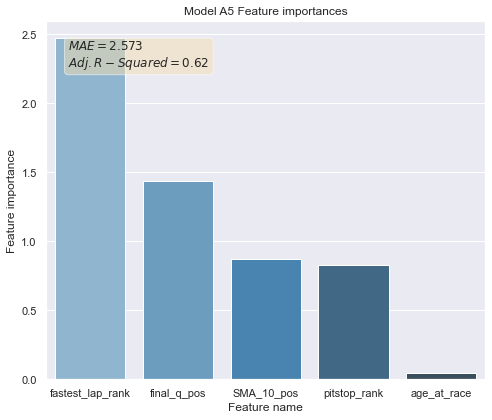

In [79]:
f, ax = plt.subplots(figsize=(7, 6))
ax = sns.barplot(x=0, y=1, data=pd.DataFrame(sorted_features_importance_a5), palette="Blues_d")
ax.set_xlabel("Feature name")
ax.set_ylabel("Feature importance")
plt.title("Model A5 Feature importances")
textstr = '\n'.join((
    r'$MAE=%.3f$' % (model_a5_test_mae, ),
    r'$Adj. R-Squared=%.2f$' % (model_a5_adj_test_r2, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()